### 2. Model, Feature Selection

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from matplotlib.pyplot import axvline, axhline
from sklearn.metrics import precision_score, accuracy_score, recall_score

In [11]:
%run Data_Preprocessing.ipynb

In [77]:
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.dummy import DummyClassifier 
# baseline confirmation, implying that model has to perform at least as good as it
# since all 3 classes respectively have 100 samples, baseline performance is 0.33
clf_dummy = DummyClassifier(strategy='most_frequent')
clf_dummy = clf_dummy.fit(X_train_, y_train_)
print('baseline score =>', round(clf.score(X_validation, y_validation), 2))

baseline score => 0.33


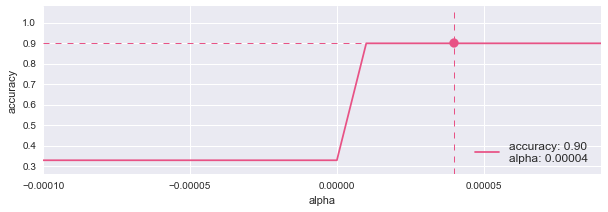

In [76]:
# go through cross validation 
# search optimal parameter that maximizes classification performance

cv = StratifiedKFold(y_train, n_folds=10, random_state=0)
score_range = []
parameter_range = []

for parameter in np.arange(-1e-4, 1e-4, 1e-5):
    clf_MNB = MultinomialNB(alpha=parameter)
    scores = np.zeros(10)

    for i, (train_idx, validation_idx) in enumerate(cv):
        X_train_ = X_train_tfidf[train_idx]
        y_train_ = y_train[train_idx]
        X_validation = X_train_tfidf[validation_idx]
        y_validation = y_train[validation_idx]
        
        clf_MNB.fit(X_train_, y_train_)
        y_predicted = clf_MNB.predict(X_validation)
        scores = round(accuracy_score(y_predicted, y_validation), 2)
        
    score_range.append(scores)
    parameter_range.append(parameter)
    dictionary = dict(zip(parameter_range, score_range))


plt.figure(figsize = (10, 3))
plt.plot(parameter_range, score_range, color='#E85285', label='accuracy: %(n)0.2f \nalpha: %(v)0.5f' % 
         {'n': max(dictionary.values()), 
          'v': max(dictionary.items(), key=lambda x: x[1])[0] })
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.legend(loc='lower right', prop={'size':12})
plt.scatter([max(dictionary.items(), key=lambda x: x[1])[0], ], [max(dictionary.values()), ], 80, color='#E85285')
axhline(max(dictionary.values()), color='#E85285', linewidth=1, linestyle='--')
axvline(max(dictionary.items(), key=lambda x: x[1])[0], color='#E85285', linewidth=1, linestyle='--')
plt.xlim(min(parameter_range), max(parameter_range))
plt.ylim(min(score_range)*0.8, max(score_range)*1.2);

In [58]:
# fit train data to the classifier with alpha being 0.00004
clf_MNB = MultinomialNB(alpha=0.00004)
clf_MNB.fit(X_train_, y_train_)
y_predicted = clf_MNB.predict(X_validation)

In [89]:
# print classification report to see the performancce of classifier
# we can see that the model has well classified class 0, data scientist.
# precision(0.91), recall(0.90), f1-score(0.90), accuracy(0.9) all far outperform the baseline (0.33).
# Though four types of scores are very similar to each other, I will focus on 'accuracy' on this project
from sklearn.metrics import classification_report, confusion_matrix
target_names = ['(0) Data Scientist', '(1) Digital Marketer', '(2) UX/UI Designer']
print(classification_report(y_validation, y_predicted, target_names=target_names))

                      precision    recall  f1-score   support

  (0) Data Scientist       0.91      1.00      0.95        10
(1) Digital Marketer       0.82      0.90      0.86        10
  (2) UX/UI Designer       1.00      0.80      0.89        10

         avg / total       0.91      0.90      0.90        30



[[10  0  0]
 [ 1  9  0]
 [ 0  2  8]]


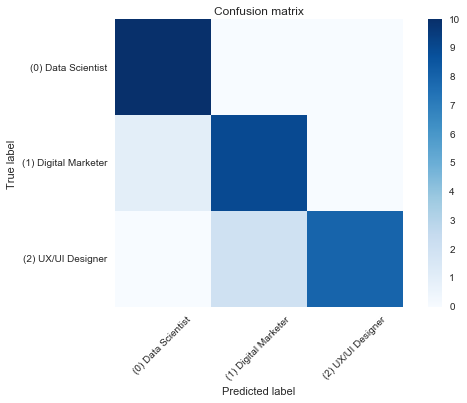

In [67]:
# this is pretty much the same as above
cm = confusion_matrix(y_validation, y_predicted)
print(cm)
plt.grid(False)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [90]:
# use pipeline to tune parameters of countvectorizer, tfidftransformer, and multinomial Naive Bayes simultaneously
# parameter tuning itself can be done by aid of GridSearhCV below
from sklearn.pipeline import Pipeline
pipeline_clf_train = Pipeline(
    steps=[
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf_MNB', MultinomialNB()),
    ]
)

In [ ]:
# the intention of including bigram is to extract noun phrasse, if necessary
# tfidf__use_idf: False was quite suprising.

from sklearn.grid_search import GridSearchCV
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf' : [True, False],
    'clf_MNB__alpha' : np.arange(0, 0.00005, 0.000005),
}
gs_clf = GridSearchCV(pipeline_clf_train, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

In [93]:
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
print('------------------------------')
print('score :', score.round(2))

clf_MNB__alpha: 1.5000000000000002e-05
tfidf__use_idf: False
vect__ngram_range: (1, 1)
------------------------------
score : 0.97
